In [50]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage import io, img_as_float
from skimage.filters import sobel
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from scipy.stats import skew, kurtosis, entropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV

In [52]:
def load_gray(img_path, size=(256, 256)):
    img = io.imread(img_path, as_gray=True)
    img = img_as_float(img)
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

In [53]:
def extract_features(img, file_path, scanner_id="unknown"):
    h, w = img.shape
    aspect_ratio = w / h
    file_size_kb = os.path.getsize(file_path) / 1024
    pixels = img.flatten()

    # Basic statistics
    mean_intensity = np.mean(pixels)
    std_intensity = np.std(pixels)
    skewness = skew(pixels)
    kurt_val = kurtosis(pixels)
    ent = entropy(np.histogram(pixels, bins=256, range=(0, 1))[0] + 1e-6)

    # Edge density
    edges = sobel(img)
    edge_density = np.mean(edges > 0.1)

    # Texture (GLCM)
    img_uint8 = (img * 255).astype(np.uint8)
    glcm = graycomatrix(img_uint8, [1], [0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    # LBP entropy
    lbp = local_binary_pattern(img_uint8, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 59), range=(0, 58))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    lbp_entropy = entropy(lbp_hist + 1e-6)

    # Frequency domain (FFT)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    fft_mean = np.mean(magnitude_spectrum)
    fft_std = np.std(magnitude_spectrum)

    return {
        "class_label": scanner_id,
        "file_size_kb": file_size_kb,
        "mean_intensity": mean_intensity,
        "std_intensity": std_intensity,
        "skewness": skewness,
        "kurtosis": kurt_val,
        "entropy": ent,
        "edge_density": edge_density,
        "contrast": contrast,
        "homogeneity": homogeneity,
        "energy": energy,
        "correlation": correlation,
        "lbp_entropy": lbp_entropy,
        "fft_mean": fft_mean,
        "fft_std": fft_std,
    }


In [54]:
columns = [
    "class_label", "file_size_kb", "mean_intensity", "std_intensity",
    "skewness", "kurtosis", "entropy", "edge_density",
    "contrast", "homogeneity", "energy", "correlation",
    "lbp_entropy", "fft_mean", "fft_std"
]

In [55]:
metadata = pd.DataFrame(columns=columns)

In [56]:
def process_image_and_append(df, img_path, scanner_id="unknown"):
    img = load_gray(img_path)
    features = extract_features(img, img_path, scanner_id)
    df.loc[len(df)] = features
    return df

In [57]:
dataset_dir = r"C:\Users\diksh\Downloads\trace finder dataset 2"

In [58]:
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.lower().endswith(('.tif', '.jpg', '.png', '.jpeg')):
            img_path = os.path.join(root, file)
            relative_path = os.path.relpath(img_path, dataset_dir)
            scanner_id = relative_path.split(os.sep)[0]
            print(f"Processing: {file} | Scanner ID: {scanner_id}")
            metadata = process_image_and_append(metadata, img_path, scanner_id)

Processing: s1_1.tif | Scanner ID: Canon120-1
Processing: s1_10.tif | Scanner ID: Canon120-1
Processing: s1_11.tif | Scanner ID: Canon120-1
Processing: s1_13.tif | Scanner ID: Canon120-1
Processing: s1_15.tif | Scanner ID: Canon120-1
Processing: s1_16.tif | Scanner ID: Canon120-1
Processing: s1_17.tif | Scanner ID: Canon120-1
Processing: s1_18.tif | Scanner ID: Canon120-1
Processing: s1_19.tif | Scanner ID: Canon120-1
Processing: s1_2.tif | Scanner ID: Canon120-1
Processing: s1_20.tif | Scanner ID: Canon120-1
Processing: s1_21.tif | Scanner ID: Canon120-1
Processing: s1_22.tif | Scanner ID: Canon120-1
Processing: s1_23.tif | Scanner ID: Canon120-1
Processing: s1_24.tif | Scanner ID: Canon120-1
Processing: s1_25.tif | Scanner ID: Canon120-1
Processing: s1_26.tif | Scanner ID: Canon120-1
Processing: s1_27.tif | Scanner ID: Canon120-1
Processing: s1_28.tif | Scanner ID: Canon120-1
Processing: s1_29.tif | Scanner ID: Canon120-1
Processing: s1_3.tif | Scanner ID: Canon120-1
Processing: s1_3

In [41]:
metadata["class_label"].value_counts()

Canon120-2     200
Canon220       200
Canon9000-1    200
Canon9000-2    200
EpsonV370-1    200
EpsonV370-2    200
EpsonV39-1     200
EpsonV550      200
HP             200
EpsonV39-2     101
Canon120-1      81
Name: class_label, dtype: int64

In [42]:
metadata = metadata.dropna()
print("\n✅ Feature extraction complete!")


✅ Feature extraction complete!


In [43]:
X = metadata.drop(columns=["class_label"], errors='ignore')
y = metadata["class_label"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [44]:
# Handle class imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y_encoded)
print(f"\nResampled dataset shape: {pd.Series(y_res).value_counts()}")


Resampled dataset shape: 0     200
1     200
2     200
3     200
4     200
5     200
6     200
7     200
8     200
9     200
10    200
dtype: int64


In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

In [46]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
# ---- Grid Search for SVM ----
svm_params = {
    'C': [0.5, 1, 5, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'poly']
}
svm = GridSearchCV(SVC(class_weight='balanced', random_state=42),
                   svm_params, cv=3, n_jobs=-1, verbose=1)
svm.fit(X_train_scaled, y_train)
print(f"Best SVM Params: {svm.best_params_}")

y_pred_svm = svm.predict(X_test_scaled)
svm_acc = accuracy_score(y_test, y_pred_svm)
print(f"\n🔹 Optimized SVM Accuracy: {svm_acc * 100:.2f}%")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best SVM Params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

🔹 Optimized SVM Accuracy: 41.14%
              precision    recall  f1-score   support

  Canon120-1       0.25      0.68      0.37        40
  Canon120-2       0.19      0.12      0.15        40
    Canon220       0.00      0.00      0.00        40
 Canon9000-1       0.20      0.03      0.04        40
 Canon9000-2       0.17      0.20      0.19        40
 EpsonV370-1       0.54      0.55      0.54        40
 EpsonV370-2       0.47      0.50      0.48        40
  EpsonV39-1       0.33      0.05      0.09        40
  EpsonV39-2       0.39      0.75      0.52        40
   EpsonV550       0.59      0.65      0.62        40
          HP       1.00      1.00      1.00        40

    accuracy                           0.41       440
   macro avg       0.38      0.41      0.36       440
weighted avg       0.38      0.41      0.36       440



In [48]:
# ---- Grid Search for Random Forest ----
rf_params = {
    'n_estimators': [200, 300, 400],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}
rf = GridSearchCV(RandomForestClassifier(random_state=42),
                  rf_params, cv=3, n_jobs=-1, verbose=1)
rf.fit(X_train, y_train)
print(f"Best RF Params: {rf.best_params_}")

y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"\n🔹 Optimized Random Forest Accuracy: {rf_acc * 100:.2f}%")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best RF Params: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 400}

🔹 Optimized Random Forest Accuracy: 47.05%
              precision    recall  f1-score   support

  Canon120-1       0.46      0.55      0.50        40
  Canon120-2       0.32      0.30      0.31        40
    Canon220       0.31      0.25      0.28        40
 Canon9000-1       0.07      0.07      0.07        40
 Canon9000-2       0.13      0.12      0.13        40
 EpsonV370-1       0.48      0.35      0.41        40
 EpsonV370-2       0.49      0.62      0.55        40
  EpsonV39-1       0.45      0.33      0.38        40
  EpsonV39-2       0.58      0.62      0.60        40
   EpsonV550       0.78      0.95      0.85        40
          HP       0.98      1.00      0.99        40

    accuracy                           0.47       440
   macro avg       0.46      0.47      0.46       440
weighted avg       0.46      

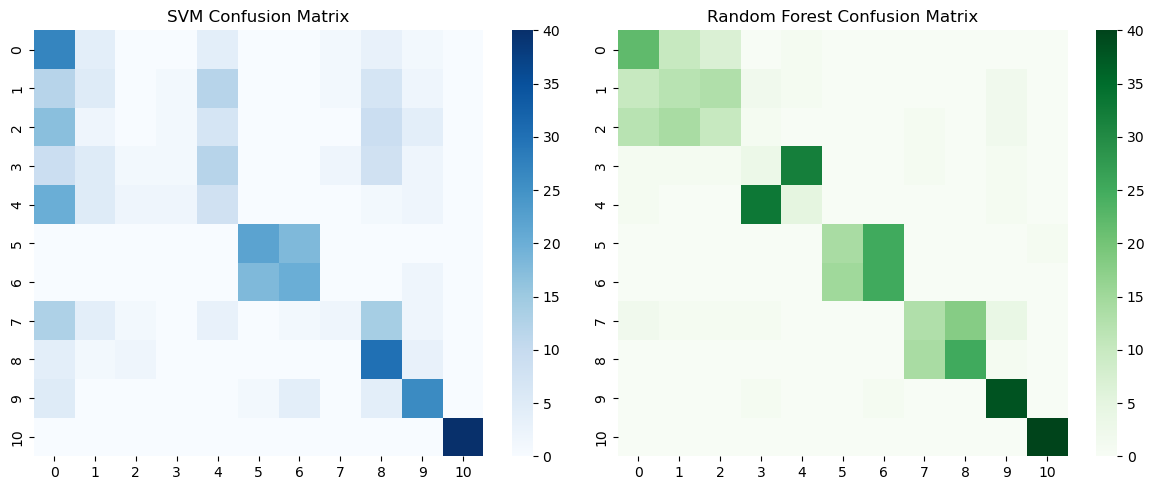

In [49]:
# Confusion Matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_svm),
            annot=False, cmap='Blues')
plt.title("SVM Confusion Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_rf),
            annot=False, cmap='Greens')
plt.title("Random Forest Confusion Matrix")

plt.tight_layout()
plt.show()